In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 주피터 노트북용 tqdm (progress bar 표시용)
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

# 일반 python용 tqdm
#from tqdm import tqdm


In [2]:
class SimpleCNN:
    def __init__(self, lr=0.001):
        # initialize convolutional filters (He initialization)
        convF1 = np.random.randn(3, 3, 1, 16) / np.sqrt(3*3/2)     # filter size: 3x3x1  x16 channels
        convF2 = np.random.randn(3, 3, 16, 32) / np.sqrt(3*3*16/2) # filter size: 3x3x16 x32 channels
        
        # initialize fully connected layer weights (He initialization)
        fcW1 = np.random.randn(7*7*32, 512) / np.sqrt(7*7*32/2)    # shape: 1568 x 512
        fcW2 = np.random.randn(512, 10) / np.sqrt(512/2)           # shape: 512 x 10
        
        # 전체 weights. 편의상 하나로 묶어서 관리
        self.weights = np.array([convF1, convF2, fcW1, fcW2])
        
        # learning rate
        self.learning_rate = lr
        
        # ADAM hyper-parameters
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.e = 1E-8
        self.time_step = 0
        # ADAM momentum & RMSProp 저장을 위한 변수
        self.m = np.array([np.zeros(self.weights[i].shape) for i in range(len(self.weights))])
        self.v = np.array([np.zeros(self.weights[i].shape) for i in range(len(self.weights))])
    
    def adam_optimization_step(self, gradient):
        # update momentum
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradient
        
        # update RMSProp
        self.v = self.beta2 * self.v + (1 - self.beta2) * gradient**2
        
        # unbias
        self.time_step += 1
        m_hat = self.m / (1 - np.power(self.beta1, self.time_step))
        v_hat = self.v / (1 - np.power(self.beta2, self.time_step))
        
        # update weights
        self.weights = self.weights - self.learning_rate * m_hat / (v_hat + self.e)**0.5
    
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    # relu'(x)
    def relu_dot(self, x):
        return (x >= 0) * 1.0
    
    def softmax(self, x):
        # 지수가 너무 커지는 것을 방지하기 위해 (overflow) 최대값으로 분모, 분자를 나눔
        e_x = np.exp(x - x.max(axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)
    
    # softmax 함수의 cross entropy 손실함수 sigma { -y ln(y_pred) }
    def cross_entropy_loss(self, y_gt, y_pred=None):
        if y_pred is None:
            y_pred = self.Y_pred
        return - (y_gt * np.log(y_pred)).sum() / y_gt.shape[0]  # N개 data에 대한 평균
    
    def accuracy(self, y_gt, y_pred=None):
        if y_pred is None:
            y_pred = self.Y_pred
        # N개 data에 대해 정답과 예측의 일치 개수 비율을 구함
        return np.equal(y_gt.argmax(axis=1), y_pred.argmax(axis=1)).sum() / y_gt.shape[0]
    
    #############################
    # convolutional function
    def conv3x3(self, x, f):
        # zero-padding
        xp = np.zeros((x.shape[0], x.shape[1] +2, x.shape[2] +2, x.shape[3]))
        xp[:, 1:-1, 1:-1, :] = x
        
        # convolutional operation  X:(N, W, H, C) * F:(w, h, C, D) ==> Y:(N, W, H, D)
        y = np.zeros((x.shape[0], x.shape[1], x.shape[2], f.shape[3]))
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                # x_fraction:(N, w, h, C, 1) * f:(w, h, C, D) --> (N, w, h, C, D) 
                #  --> 2,3,4차원 합계 --> (N, 1, D)
                #  --> W, H 만큼 반복하며 broadcasting --> (N, W, H, D)
                y[:, i, j, :] = np.sum(xp[:, i:i+3, j:j+3, :, None] * f, axis=(1,2,3))
        return y
    
    #############################
    # convolutional backpropagation (conv. layer를 통한 error map 역전파)
    def conv3x3_backprop(self, err_map, f):
        # error map과 뒤집힌 filter 사이의 convolutional 연산과 동일함
        # filter는 w(0), h(1)를 뒤집고, input channel(2)과 output channel(3)을 뒤집어야 함 (transpose(1,0,3,2))
        return self.conv3x3(err_map, f.transpose(1,0,3,2))
    
    #############################
    # convolutional filter gradient 계산
    def conv3x3_gradient(self, err_map, x):
        # zero-padding
        xp = np.zeros((x.shape[0], x.shape[1] +2, x.shape[2] +2, x.shape[3]))
        xp[:, 1:-1, 1:-1, :] = x
        
        # convolutional operation channel by channel  X:(N, W, H, C) * Err:(N, W, H, D) ==> F:(w, h, C, D)
        grad_f = np.zeros((3, 3, x.shape[3], err_map.shape[3]))
        for i in range(grad_f.shape[0]):
            for j in range(grad_f.shape[1]):
                # x:(N, W, H, C, 1) * err:(N, W, H, 1, D) --> (N, W, H, C, D)
                #  --> 1,2,3차원 합계 --> (1, C, D)
                #  --> w, h 만큼 반복 --> (w, h, C, D)
                grad_f[i, j, :, :] = np.sum(xp[:, i:i+x.shape[1], j:j+x.shape[2], :, None] * err_map[:, :, :, None, :], axis=(0,1,2))
        return grad_f
    
    #############################
    # max-pooling function
    def pool2x2(self, x):
        # input 크기가 2의 배수라면 reshape와 max 함수로 구현 가능
        return x.reshape(x.shape[0], x.shape[1]//2, 2, x.shape[2]//2, 2, x.shape[3]).max(axis=(2, 4))
    
    #############################
    # max-pooling backpropagation (max-pooling layer를 통한 error map 역전파)
    def pool2x2_backprop(self, err_map, x, y):
        # max-pooling 출력의 dimension이 입력의 demension과 같아지도록 2x2 반복
        # 이를 입력 값과 비교하여 값이 같다면 1, 다르다면 0으로 mask 셋팅
        mask = np.equal(x, y.repeat(2, axis=1).repeat(2, axis=2))
        
        # error map 또한 입력 dimension과 같아지도록 2x2 반복
        err_map_upscale = err_map.repeat(2, axis=1).repeat(2, axis=2)
        
        # error map과 mask를 (elementwise) 곱하여 error map 역전파
        return mask * err_map_upscale
    
    
    def decay_learning_rate(self, rate):
        self.learning_rate *= rate
        return self.learning_rate
    
    def feedforward(self, x):
        # input layer
        self.X = np.reshape(x, (-1, 28, 28, 1))             # --> (N, H=28, W=28, C=1)
        
        # convolutional layer 1 - relu activation
        self.C1i = self.conv3x3(self.X, self.weights[0])    # --> (N, 28, 28, 16)
        self.C1 = self.relu(self.C1i)
        # max pooling layer
        self.P1 = self.pool2x2(self.C1)                     # --> (N, 14, 14, 16)
        
        # convolutional layer 2 - relu activation
        self.C2i = self.conv3x3(self.P1, self.weights[1])   # --> (N, 14, 14, 32)
        self.C2 = self.relu(self.C2i)
        # max pooling layer
        self.P2 = self.pool2x2(self.C2)                     # --> (N, 7, 7, 32)
        
        # flatten
        self.FL = self.P2.reshape(-1, 7*7*32)               # --> (N, 7*7*32)
        
        # fully connected layer - relu activation
        self.FCi = np.dot(self.FL, self.weights[2])         # --> (N, 512)
        self.FC = self.relu(self.FCi)
        
        # output layer - softmax activation
        self.Y_pred = self.softmax(np.dot(self.FC, self.weights[3]))  # --> (N, 10)
        return self.Y_pred
    
    
    def train_step(self, x, y_gt):
        # feedforward
        y_pred = self.feedforward(x)
        
        # loss & accuracy
        y = np.reshape(y_gt, (-1, 10))
        ff_loss = self.cross_entropy_loss(y, y_pred)
        ff_acc = self.accuracy(y, y_pred)
        
        # backpropagation
        #  <-- output layer <--
        errmap = (y_pred - y)                   # dL/dy * softmax_dot         # (N, 10)
        grad_W2 = np.dot(self.FC.T, errmap)                                   # (512, 10)
        errmap = np.dot(errmap, self.weights[3].T)                            # (N, 512) <--
        
        #  <-- fully connected layer <--
        errmap = errmap * self.relu_dot(self.FCi)
        grad_W1 = np.dot(self.FL.T, errmap)                                   # (1568, 512)
        errmap = np.dot(errmap, self.weights[2].T).reshape(-1, 7, 7, 32)      # (N, 7, 7, 32) <--
        
        #  <-- max pooling layer <--
        errmap = self.pool2x2_backprop(errmap, self.C2, self.P2)              # (N, 14, 14, 32) <--
        
        #  <-- convolutional layer <--
        errmap = errmap * self.relu_dot(self.C2i)
        grad_F2 = self.conv3x3_gradient(errmap, self.P1)                      # (3, 3, 16, 32)
        errmap = self.conv3x3_backprop(errmap, self.weights[1])               # (N, 14, 14, 16) <--
        
        #  <-- max pooling layer <--
        errmap = self.pool2x2_backprop(errmap, self.C1, self.P1)              # (N, 28, 28, 16) <--
        
        #  <-- convolutional layer <--
        errmap = errmap * self.relu_dot(self.C1i)
        grad_F1 = self.conv3x3_gradient(errmap, self.X)                       # (3, 3, 1, 16)
        
        # 각 gradient는 총 N(=batch_size) 개의 data에 대한 합 형태로 계산됐으므로 N으로 나누어야 함
        num_data = y.shape[0]
        gradients = np.array([grad_F1, grad_F2, grad_W1, grad_W2]) / num_data
        
        # optimization (GDM)
        #self.weights = self.weights - self.learning_rate * gradients;
        
        # optimization (ADAM)
        self.adam_optimization_step(gradients)
        
        # feedforward 직후 (학습 step 수행 전) loss와 accuracy 값을 return
        return ff_loss, ff_acc
    

In [3]:
# Training
epoch = 10
batch_size = 32
learning_rate = 0.001
decay_rate = 0.8
num_training_data = 50000

net = SimpleCNN(lr=learning_rate)

# training data loading
training_dataset_file = open("mnist_train.csv", 'r')
training_dataset_list = training_dataset_file.readlines()
training_dataset_file.close()

# training data의 input과 정답을 각각 list에 저장
input_list = list()
target_list = list()
for i in training_dataset_list:
    all_values = i.split(',')
    inputs = (np.asfarray(all_values[1:])/255.0*0.99)+0.01
    input_list.append(inputs)
    
    targets = np.zeros(10) + 0.001
    targets[int(all_values[0])] = 0.991   # sum to 1
    target_list.append(targets)
    
# training, validation으로 나눔
training_input_list = input_list[:num_training_data]
training_target_list = target_list[:num_training_data]
validation_input_list = input_list[num_training_data:]
validation_target_list = target_list[num_training_data:]

del(input_list)
del(target_list)

In [4]:
training_loss_list = list()
validation_loss_list = list()

# 전체 반복 횟수 counting을 위한 변수
num_iter = 0

# epoch loop
for k in range(epoch):
    # epoch 마다 learning rate 감소
    if k != 0:
        learning_rate = net.decay_learning_rate(decay_rate)
    
    # epoch 마다 mini batch 순서 변경
    permute_indices = np.random.permutation(len(training_input_list))
    
    # training용 mini batch 반복 및 progress bar 설정
    tr = tqdm(range(0, len(training_input_list), batch_size));
    tr.set_description('Training: %i epoch' % (k+1))
    
    # training loop
    # 모든 mini batch에 대해 학습 수행
    for i in tr:
        batch_indices = permute_indices[i:i+batch_size]
        x = [training_input_list[ii] for ii in batch_indices]
        y = [training_target_list[ii] for ii in batch_indices]
        
        # 학습 1회 실시
        loss, acc = net.train_step(x, y)
        
        # 각 반복의 training accuracy, loss, learning rate를 progress bar 화면에 표시
        tr.set_postfix(loss=loss, accuracy=acc, learning_rate=learning_rate)
        
        # 그래프 출력을 위한 training loss 값 저장
        training_loss_list.append((num_iter, loss, acc))
        num_iter += 1
    
    
    # validation용 mini batch 반복 및 progress bar 설정
    va = tqdm(range(0, len(validation_input_list), batch_size));
    va.set_description('Validation: %i epoch' % (k+1))
    
    # validation loop
    # mini batch 단위로 수행하여 합계를 구한 후, validation data 개수로 나누어 평균을 구함
    va_loss_sum = 0
    va_acc_sum = 0
    for i in va:
        x = validation_input_list[i:i+batch_size]
        y = validation_target_list[i:i+batch_size]
        # feedforward
        y_pred = net.feedforward(x)
        y = np.reshape(y, (-1, 10))
        # validation loss, accuracy 총합 누적
        va_loss_sum += net.cross_entropy_loss(y, y_pred) * len(x)
        va_acc_sum += net.accuracy(y, y_pred) * len(x)
    
    # validation loss, accuracy 평균 계산
    va_loss = va_loss_sum / len(validation_input_list)
    va_acc = va_acc_sum / len(validation_input_list)
    print('validation accuracy=%f, loss=%f' % (va_acc, va_loss))
    
    # 그래프 출력을 위한 validation loss 값 저장
    validation_loss_list.append((num_iter, va_loss, va_acc))
    

A Jupyter Widget

A Jupyter Widget


validation accuracy=0.985600, loss=0.131851


A Jupyter Widget

A Jupyter Widget


validation accuracy=0.990200, loss=0.116541


A Jupyter Widget

A Jupyter Widget


validation accuracy=0.988700, loss=0.116153


A Jupyter Widget

A Jupyter Widget


validation accuracy=0.991800, loss=0.105831


A Jupyter Widget

A Jupyter Widget


validation accuracy=0.992800, loss=0.102014


A Jupyter Widget

A Jupyter Widget


validation accuracy=0.993000, loss=0.099741


A Jupyter Widget

A Jupyter Widget


validation accuracy=0.993600, loss=0.097547


A Jupyter Widget

A Jupyter Widget


validation accuracy=0.993800, loss=0.097079


A Jupyter Widget

A Jupyter Widget


validation accuracy=0.994000, loss=0.095878


A Jupyter Widget

A Jupyter Widget


validation accuracy=0.994000, loss=0.095508


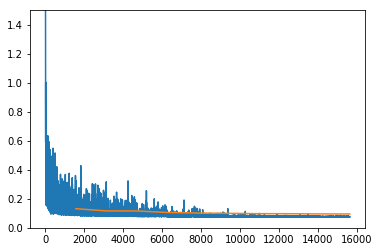

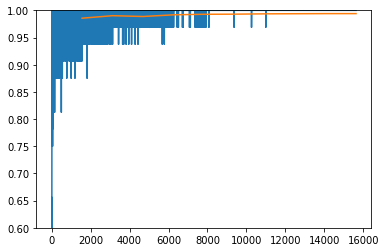

In [5]:
tr_history = np.array(training_loss_list)
va_history = np.array(validation_loss_list)

# 학습과정에 따른 loss 변화 그래프
# (파란색: training data, 주황색: validation data)
fig_loss = plt.plot(tr_history[:,0], tr_history[:,1], va_history[:,0], va_history[:,1])
plt.ylim(0, 1.5)
plt.show(fig_loss)

# 학습과정에 따른 accuracy 변화 그래프
# (파란색: training data, 주황색: validation data)
fig_acc = plt.plot(tr_history[:,0], tr_history[:,2], va_history[:,0], va_history[:,2])
plt.ylim(0.6, 1)
plt.show(fig_acc)

In [6]:
# Test
test_dataset_file = open("mnist_test.csv", 'r')
test_dataset_list = test_dataset_file.readlines()
test_dataset_file.close()
output_list = list()

In [7]:
# test error rate
success = 0
failure = 0

for i in tqdm(test_dataset_list):
    all_values = i.split(',')
    target = int(all_values[0])
    
    #inputs = (np.asfarray(all_values[1:])/255.0*0.99)+0.01
    prediction_list = net.feedforward(np.asfarray(all_values[1:]))
    prediction = np.argmax(prediction_list)
    
    if target == prediction:
        success = success + 1
        #print("Prediction is successful. (target, predcition) = ", target, prediction)
    else:
        failure = failure + 1
        #print("Prediction fails. (target, predcition) = ", target, prediction)
        
print("Recognition error rate = ", (failure/(success+failure)))
print("Recognition accuracy = ", (success/(success+failure)) * 100, "%")

A Jupyter Widget


Reconition error rate =  0.0068
Reconition accuracy =  99.32 %
